In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
# 1. Đọc file CSV và xử lý dữ liệu
from google.colab import files
uploaded = files.upload()

Saving hanoi_quality.csv to hanoi_quality.csv


In [6]:
data = pd.read_csv("hanoi_quality.csv", parse_dates=['date'], dayfirst=True)
data = data.set_index('date')

df1 = data['pm25']

scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

# 2. Chia train test
train_size = int(len(df1) * 0.7)
test_size = len(df1) - train_size
train_data, test_data = df1[0:train_size, :], df1[train_size:len(df1), :]

In [8]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
# 3. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [10]:
# 4. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

# 5. Dự báo dữ liệu test
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/100
20/20 [==============================] - 16s 151ms/step - loss: 0.0397 - val_loss: 0.0317
Epoch 2/100
20/20 [==============================] - 2s 79ms/step - loss: 0.0226 - val_loss: 0.0308
Epoch 3/100
20/20 [==============================] - 2s 108ms/step - loss: 0.0207 - val_loss: 0.0296
Epoch 4/100
20/20 [==============================] - 2s 105ms/step - loss: 0.0202 - val_loss: 0.0304
Epoch 5/100
20/20 [==============================] - 1s 70ms/step - loss: 0.0202 - val_loss: 0.0298
Epoch 6/100
20/20 [==============================] - 1s 66ms/step - loss: 0.0203 - val_loss: 0.0297
Epoch 7/100
20/20 [==============================] - 1s 64ms/step - loss: 0.0196 - val_loss: 0.0293
Epoch 8/100
20/20 [==============================] - 1s 65ms/step - loss: 0.0197 - val_loss: 0.0290
Epoch 9/100
20/20 [==============================] - 1s 65ms/step - loss: 0.0194 - val_loss: 0.0291
Epoch 10/100
20/20 [==============================] - 1s 65ms/step - loss: 0.0194 - val_loss: 0.

In [11]:
# 6. Đánh giá mô hình
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true, axis=0)
    y_pred_diff = np.diff(y_pred, axis=0)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

test_score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_score_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_score_mda = calculate_mda(y_test, y_pred)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 34.07017436405876
MAPE trên tập test là: 116.69258023024058 %
MDA trên tập test là: 44.48742746615087 %


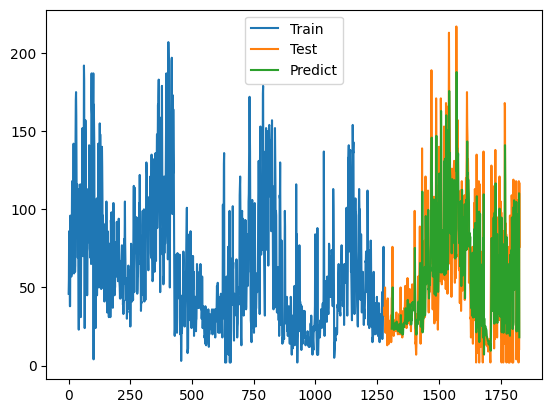

In [12]:
# 7. Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=len(df1), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))
pred_data_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + time_step + len(y_pred), step=1)
plt.plot(pred_data_index, y_pred)
plt.legend(['Train', 'Test', 'Predict'])
plt.show()